In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import cv2

In [3]:
PATH = Path('/kaggle/input/comma-speed-challenge')
IM_PATH = Path('/kaggle/input/commadatapipeline/')
OUT_PATH = Path('/kaggle/working')

In [4]:
files = sorted(os.listdir(PATH/'train/train'))
files = files[2:]   # remove trash directory at the beginning
len(files)

20400

In [5]:
flows = sorted(os.listdir(IM_PATH/'flow'))
len(flows)

20400

In [6]:
speeds = np.loadtxt(PATH/'train.txt')
print(len(speeds))

20400


In [7]:
df = DataFrame({'filenames': flows, 'labels': speeds})
df.head()

,filenames,labels
0,output_00001.png,28.105569
1,output_00002.png,28.105569
2,output_00003.png,28.106527
3,output_00004.png,28.130404
4,output_00005.png,28.109243


In [ ]:
# class ImagePairList(ImageList):
#     def get(self, i):
#         im2 = super().get(i)
#         im1 = super().get(i-1)
#         # crop out dash and roof and concatenate images vertically
#         return Image( torch.cat([im1.data[:,50:300,:], im2.data[:,50:300,:]], dim=1) )

In [12]:
def denseOptFlow(prv, nxt):
    "Input grayscale images"
    # params = {prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0}
    flow = cv2.calcOpticalFlowFarneback(prv, nxt, None, 0.5, 1, 5, 1, 5, 1.1, 0)
    #flow = cv2.calcOpticalFlowFarneback(prv,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)  #ex from opencv docs
    # => optical flow vectors (2 channels)
                              
    # convert from cartesian to polar to get magnitude and angle of flow vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    hue = ang * (180/ np.pi / 2)   # hue corresponds to direction  max=180
    sat = np.zeros_like(nxt, dtype= np.float32) + 255   # set saturation to constant
    val = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)   # value corresponds to magnitude normalized to 0-255
        
    hsv = np.stack([hue,sat,val], axis=-1)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

In [13]:
# dynamically create flow images  ->  too slow
class FlowList(ImageList):
    def get(self, i):        
        im1 = cv2.imread(self.items[i-1],0)
        im2 = cv2.imread(self.items[i],0)
        flow = denseOptFlow(im1[50:300,:],im2[50:300,:])
        res = self.open_flow(flow)
        self.sizes[i] = res.size
        return res    

    def open_flow(self, x):
        "Convert cv2 image into torch.tensor and normalize"
        x = torch.from_numpy(np.transpose(x, (2,0,1)))
        x = torch.clamp(x, 0, 255)
        return Image(x.div(255))

In [10]:
# suppress annoying scale_factor warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [72]:
tfms = ([flip_lr(p=0.5,use_on_y=False)],[])
#tfms = get_transforms(max_rotate=0, max_warp=0, max_lighting=0.3)

In [81]:
data = (ImageList.from_df(df, IM_PATH/'flow')   #FlowList.from_df(df, PATH/'train/train')
        .split_by_rand_pct(seed=42)
        .label_from_df()
        .transform([], size=(64,128))
        .databunch(bs=64)
        #.normalize()
       )

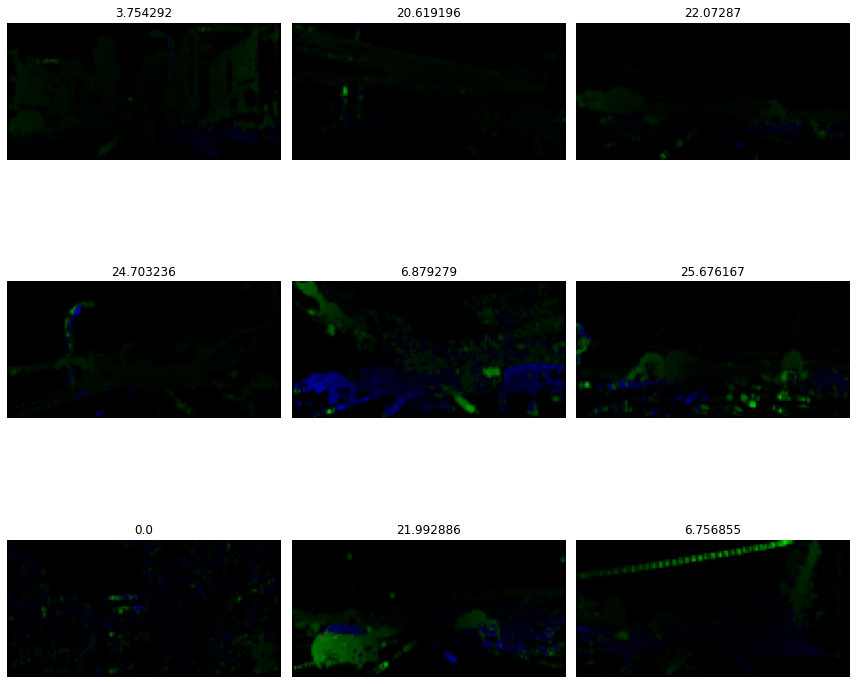

In [74]:
data.show_batch(3)

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [31]:
class Model(Module):
    def __init__(self, top_speed=30):
        self.max = top_speed
        self.body = nn.Sequential(*list(models.resnet34().children())[:-1], Flatten()) # 256
#         self.head = create_head(512,1,[128,32],ps=[0.2,0.2,0.2])   # concat_pool => 512
        self.head = nn.Linear(512,1)
        
    def forward(self, x):
        return self.head(self.body(x))
        return torch.clamp(x,0,self.max)

In [79]:
class Model(Module):
    def __init__(self, top_speed=30):
        self.max = top_speed
        self.body = models.xresnet18_deep(c_out=1) #nn.Sequential(*list(models.xresnet34().children())[:-4])
        #self.body = models.Darknet([3,3,3,3], 1)
        
    def forward(self, x):
        x = self.body(x)
        return torch.clamp(x,0,self.max)

In [82]:
# models.xresnet34(c_out=1)
learn = Learner(data, Model(), loss_func=MSELossFlat(), path=OUT_PATH)
learn.fit_one_cycle(5, 1e-2)
# fit_one_cycle(1, 1e-2)
# 0	0.875569	26.932148	10:17
# 0	1.928598	17.797274	06:26  w/normalize(); bs:128,sz:128

# flow images
# xresnet34(c_out=1), bs:64
# 0	13.365271	9.788229	03:03  no transforms, no normalize, (300x640)
# 0	6.620317	4.492767	02:22  "", sz=(64,128) **
# 0	7.056894	5.112493	02:10  "", sz=128
# 0	7.695619	4.883166	02:27  "", sz=64
# 0	7.479023	4.530056	02:26  "", w/ normalize()
# 0	11.603626	8.108723	02:32  "", w/ tfms
# 0	7.470808	4.633345	02:26  cut model at 256 add linear and scaled sigmoid
# 0	13.230696	5.245368	02:17  "", cut model at 256, linears: [128,32], no scaling
# 0	8.496896	5.968565	02:16  xresnet50
# 0	8.088330	5.396023	02:10  w/ scaled sigmoid
# 0	7.489454	4.517018	02:11  w/ torch.clamp(0,30)

# 0	7.719754	52.457222	12:49  dynamic flow images in dataloader
# 0	7.044945	5.021362	02:22  resnet34
# 0	18.986565	15.860154	02:04  darknet[1,1,1]
# 0	12.864654	9.772768	02:04  darknet[1,1,1,1]
# 0	11.398129	7.830225	02:06  darknet[2,2,2,2]
# 0	11.530082	7.631916	02:11  darknet[2,2,2,2]
# 0	7.113442	4.226642	02:11  xresnet34_deep(c_out=1)
# 0	6.941132	3.741658	02:06  xresnet18_deep(c_out=1)

# fit_one_cycle(3, 1e-2), bs:64, sz=(64,128)
# 2	1.541236	1.206637	02:23  xresnet34(c_out=1)
# 2	3.482277	2.603734	02:33  "", w/ tfms()  -  transforms include random crop!
# 2	1.030466	0.942322	02:05  xresnet18_deep(c_out=1)
# 0	0.798674	0.786779	02:05  "", fit_one_cycle(1,1e-3)  **
# 2	2.304058	1.959610	02:08  xresnet18_deep(c_out=1), w/ flip_lr(0.5)

# fit_one_cycle(5, 1e-2), bs:64, sz=(64,128)
# 4	1.078275	1.046482	02:21  xresnet34_deep(c_out=1), w/ flip_lr
# 4	1.036778	1.123643	02:19  xresnet18_deep(c_out=1), w/ flip_lr
# 4	0.385657	0.474562	02:12  xresnet18_deep(c_out=1)  ** 

epoch,train_loss,valid_loss,time
0,12.114258,6.636534,02:18
1,4.146969,9.591491,02:18
2,2.024222,1.710289,02:21
3,0.773663,0.660254,02:28
4,0.385657,0.474562,02:12


In [ ]:
preds,targs = learn.get_preds()

In [ ]:
mse(preds,targs)

In [ ]:
print(preds[:10],targs[:10])

# DenseOptFlow

In [ ]:
def show_mult(ims):
    fig,axes = plt.subplots(1,len(ims))
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for ax,im in zip(axes,ims):
        ax.imshow(im)

In [ ]:
im1 = cv2.imread(str(PATH/'train/train/output_00675.png'),0)  # 0 flag: load as grayscale
im2 = cv2.imread(str(PATH/'train/train/output_00676.png'),0)

In [ ]:
show_mult([im1,im2])

In [ ]:
def denseOptFlow(prv, nxt):
    "Input grayscale images"
    # params = {prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0}
    flow = cv2.calcOpticalFlowFarneback(prv, nxt, None, 0.5, 1, 5, 1, 5, 1.1, 0)
    #flow = cv2.calcOpticalFlowFarneback(prv,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)  #ex from opencv docs
    # => optical flow vectors (2 channels)
                              
    # convert from cartesian to polar to get magnitude and angle of flow vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    hue = ang * (180/ np.pi / 2)   # hue corresponds to direction  max=180
    sat = np.zeros_like(nxt, dtype= np.float32) + 255   # set saturation to constant
    val = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)   # value corresponds to magnitude normalized to 0-255
        
    hsv = np.stack([hue,sat,val], axis=-1)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

In [ ]:
flow = denseOptFlow(im1,im2)
show_mult([flow[:,:,0],flow[:,:,1]])

In [ ]:
flow.shape

In [ ]:
img = open_image(PATH/'train/train/output_00675.png')
img.data.shape

In [ ]:
# Create flow images from files
def flowImages(in_path, out_path, files):
    if not os.path.exists(out_path): os.makedirs(out_path)
    for i in range(len(files)):        
        im1 = cv2.imread(in_path+files[i-1],0)  # 0 flag: load as grayscale
        im2 = cv2.imread(in_path+files[i],0)
        out = denseOpticalFlow(im1[50:300,:],im2[50:300,:])  # crop out roof and dash
        cv2.imwrite(out_path+files[i],out)

In [ ]:
flowImages('/kaggle/input/comma-speed-challenge/train/train/', 'flow/', files[:5])